# Initial Exploration

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("../data/raw/Agrofood_co2_emission.csv")

relevant_columns = ['Year', 'Area', 'total_emission', 'Savanna fires', 'Forest fires']
df = df[relevant_columns]

In [3]:
# Print data
print(df.head())
print("Time range: ", df['Year'].unique())

   Year         Area  total_emission  Savanna fires  Forest fires
0  1990  Afghanistan     2198.963539        14.7237        0.0557
1  1991  Afghanistan     2323.876629        14.7237        0.0557
2  1992  Afghanistan     2356.304229        14.7237        0.0557
3  1993  Afghanistan     2368.470529        14.7237        0.0557
4  1994  Afghanistan     2500.768729        14.7237        0.0557
Time range:  [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020]


In [4]:
# Remove duplicates

# Check for exact duplicates across all columns
exact_duplicates = df.duplicated().sum()
print(f"Exact duplicates found: {exact_duplicates}")

# View duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Total rows involved in duplication: {len(duplicate_rows)}")

# Check duplicates on specific key columns
key_duplicates = df.duplicated(subset=['Year', 'Area']).sum()
print(f"Duplicates based on Year and Area: {key_duplicates}")

# Remove exact duplicates (keep first occurrence)
df_cleaned = df.drop_duplicates(keep='first')
df_cleaned = df_cleaned.dropna(subset=relevant_columns)

cleaning_log = {
    'original_rows': len(df),
    'exact_duplicates_removed': len(df) - len(df_cleaned),
    'final_rows': len(df_cleaned)
}
print(f"Cleaning summary: {cleaning_log}")

summary = pd.DataFrame({
    'Feature Name': df.columns,
    'Type': df.dtypes,
    'Missing?': df.isnull().mean().round(2),
    'Unique Values': df.nunique()
})
print('Feature summary table: ', summary)

Exact duplicates found: 0
Total rows involved in duplication: 0
Duplicates based on Year and Area: 0
Cleaning summary: {'original_rows': 6965, 'exact_duplicates_removed': 93, 'final_rows': 6872}
Feature summary table:                    Feature Name     Type  Missing?  Unique Values
Year                      Year    int64      0.00             31
Area                      Area   object      0.00            236
total_emission  total_emission  float64      0.00           6899
Savanna fires    Savanna fires  float64      0.00           3746
Forest fires      Forest fires  float64      0.01           2962


<Axes: title={'center': 'Total Emission Over Years'}, xlabel='Area'>

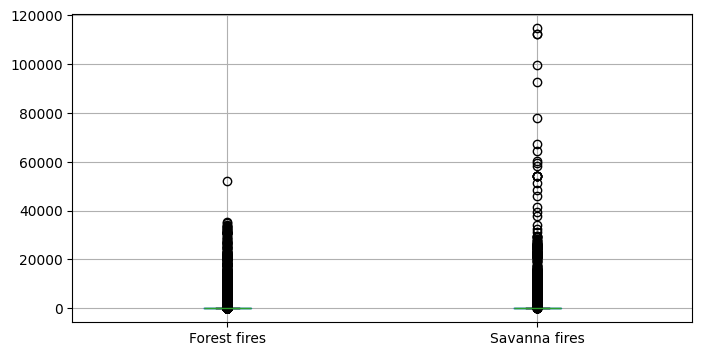

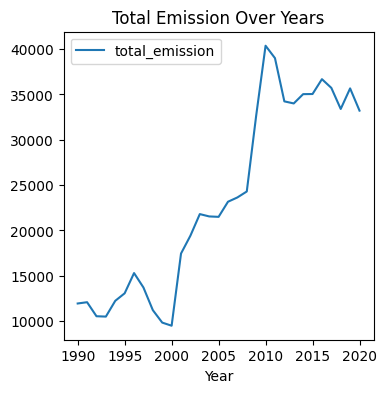

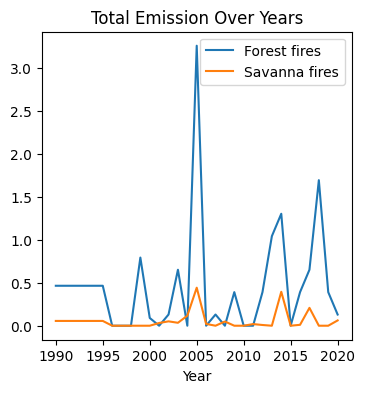

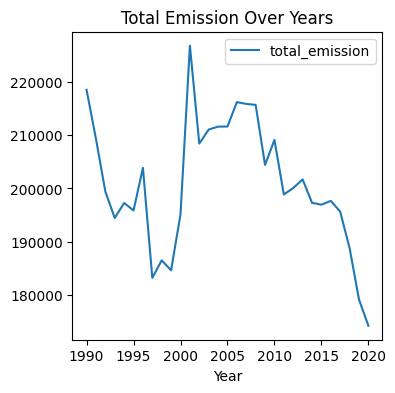

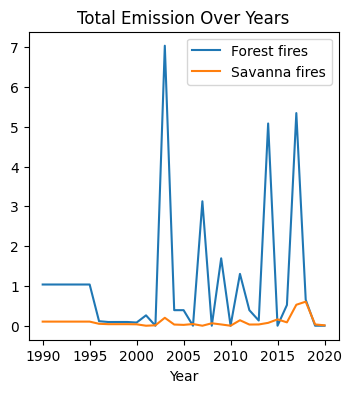

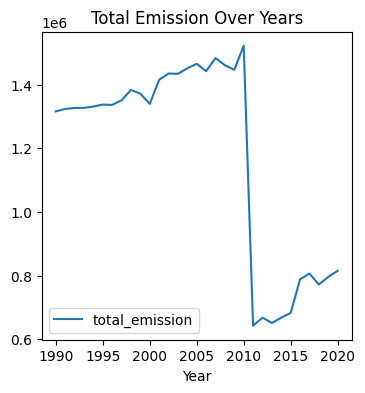

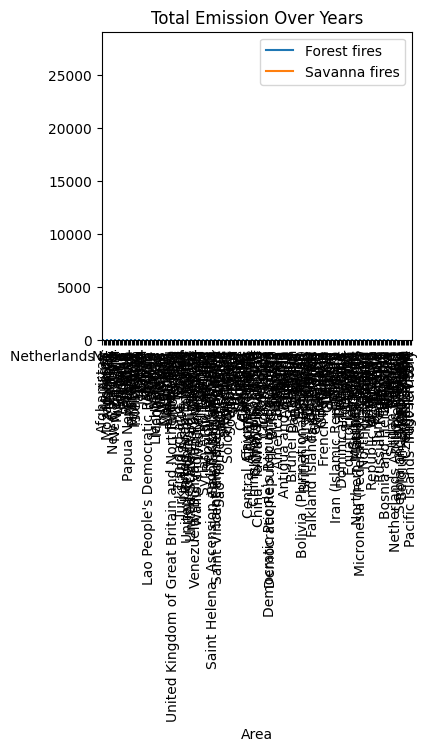

In [5]:
# Visualize features I want to use as variables

df_cleaned.boxplot(figsize=(8, 4), column=["Forest fires", "Savanna fires"])

# Print data for Austria
df_cleaned[df_cleaned['Area'] == "Austria"].plot(x='Year', y=['total_emission'], figsize=(4, 4), title='Total Emission Over Years')
df_cleaned[df_cleaned['Area'] == "Austria"].plot(x='Year', y=['Forest fires', 'Savanna fires'], figsize=(4, 4), title='Total Emission Over Years')

# Print data for Germany
df_cleaned[df_cleaned['Area'] == "Germany"].plot(x='Year', y=['total_emission'], figsize=(4, 4), title='Total Emission Over Years')
df_cleaned[df_cleaned['Area'] == "Germany"].plot(x='Year', y=['Forest fires', 'Savanna fires'], figsize=(4, 4), title='Total Emission Over Years')

# Print data for Brazil
df_cleaned[df_cleaned['Area'] == "Brazil"].plot(x='Year', y=['total_emission'], figsize=(4, 4), title='Total Emission Over Years')
df_cleaned[df_cleaned['Area'] == "Brazil"].plot(x='Year', y=['Forest fires', 'Savanna fires'], figsize=(4, 4), title='Total Emission Over Years')

df_cleaned['Area'].value_counts().plot(kind='bar')

In [6]:
# Split data

split_date = 2013
train_data = df_cleaned[df_cleaned['Year'] < split_date]
test_data = df_cleaned[df_cleaned['Year'] >= split_date]

X_train = train_data.drop(columns=train_data.columns.difference(['Area', 'Savanna fires', 'Forest fires']))
y_train = train_data['total_emission']
X_test = test_data.drop(columns=test_data.columns.difference(['Area', 'Savanna fires', 'Forest fires']))
y_test = test_data['total_emission']

print("Training data size: ", train_data.shape[0])
print("Test data size: ", test_data.shape[0])
print("Percent of total data (train): ", train_data.shape[0] / df_cleaned.shape[0] * 100)
print("Percent of total data (test): ", test_data.shape[0] / df_cleaned.shape[0] * 100)

Training data size:  5080
Test data size:  1792
Percent of total data (train):  73.9231664726426
Percent of total data (test):  26.07683352735739


In [7]:
def identify_quality_issues(df):
    """Comprehensive data quality assessment"""
    issues = {}
    
    # Check for impossible values (domain-specific)
    if 'temperature' in df.columns:
        impossible_temps = df[(df['temperature'] < -50) | (df['temperature'] > 70)]
        issues['impossible_temperatures'] = len(impossible_temps)
    
    if 'energy_consumption' in df.columns:
        negative_energy = df[df['energy_consumption'] < 0]
        issues['negative_energy'] = len(negative_energy)
    
    # Check for future dates
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        future_dates = df[df['timestamp'] > datetime.now()]
        issues['future_dates'] = len(future_dates)
    
    # Check for format inconsistencies
    for col in df.select_dtypes(include=['object']).columns:
        unique_patterns = df[col].astype(str).str.len().value_counts()
        if len(unique_patterns) > 10:  # Many different lengths suggest format issues
            issues[f'{col}_format_inconsistency'] = len(unique_patterns)
    
    return issues

# Run quality assessment
quality_report = identify_quality_issues(df_cleaned)
print("Data Quality Issues Found:")
for issue, count in quality_report.items():
    if count > 0:
        print(f"  {issue}: {count} records")

Data Quality Issues Found:
  Area_format_inconsistency: 31 records


In [8]:
def apply_one_hot_encoding(X_train, categorical_features):
    """Apply one-hot encoding to categorical features"""
    
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit encoder on training data
    encoded_features = encoder.fit_transform(X_train[categorical_features])
    
    # Get feature names
    feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Create DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=X_train.index)
    
    return encoded_df, encoder

# Example usage
categorical_features = ['Area']
X_train_encoded, fitted_encoder = apply_one_hot_encoding(X_train, categorical_features)
X_test_encoded = fitted_encoder.transform(X_test[categorical_features])

In [9]:
# Cross validate

# Basic K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model performance
model = LinearRegression()
cv_scores = cross_val_score(model, X_train_encoded, y_train, cv=kfold, 
                           scoring='neg_mean_squared_error')

print("Cross-validation scores (negative MSE):", cv_scores)

Cross-validation scores (negative MSE): [-5.16280340e+09 -4.15112391e+09 -4.09339382e+09 -3.30658571e+09
 -4.92695693e+09]


In [10]:
# Statistical preprocessing pipeline

# CORRECT: Learn all parameters from training data only
def create_preprocessing_pipeline(X_train, y_train):
    """Create preprocessing pipeline fitted on training data"""
    
    # 1. Missing value imputation
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    
    # 2. Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    
    # 3. Feature selection
    selector = SelectKBest(f_regression, k=10)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    
    # Return fitted preprocessors and transformed data
    preprocessors = {
        'imputer': imputer,
        'scaler': scaler,
        'selector': selector
    }
    
    return X_train_selected, preprocessors

def apply_preprocessing_pipeline(X_test, preprocessors):
    """Apply training preprocessing to test data"""
    
    # Apply in same order as training
    X_test_imputed = preprocessors['imputer'].transform(X_test)
    X_test_scaled = preprocessors['scaler'].transform(X_test_imputed)
    X_test_selected = preprocessors['selector'].transform(X_test_scaled)
    
    return X_test_selected

# Usage
X_train_processed, fitted_preprocessors = create_preprocessing_pipeline(X_train_encoded, y_train)
X_test_processed = apply_preprocessing_pipeline(X_test_encoded, fitted_preprocessors)

/Users/lukasbals/tomorrow-university/10_regression/sustainability-predictor/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
